# <b>NBA Champion Predictive Model Analysis</b>
#### The goal of the analysis is to see if the NBA Champion can be predicted using regular-season stats.

In [1]:
##Import relevant packages
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import shap
from pandas import json_normalize
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             ndcg_score, r2_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
most_recent = 2022
last_3 = 3
year_cutoff = 1980

## <b>Data</b>
#### Data is obtained with automated HTML parsing from [Basketball Reference](https://www.basketball-reference.com/), a site that has detailed stats on every NBA game dating back to 1950, though the more advanced stats were introduced later on (for example, 3-pointer became official in 1979). It also includes some additional information on previously won individual awards of players on a team. For example, for the 2022 Philadelphia 76ers, its players have a combined 13 All-NBA team nominations, 8 All-NBA defensive team selections, 3 NBA Championships, etc.. 
#### The original data contains 92 columns and 1573 rows, with a time ranging between 1950 and 2022. The data contains some "NaN" values, most of which originate from the missing stats from the early period between 1950 to 1980. As a result, we choose to remove all data before the 1980 season as the data after 1980 contains no empty value.

In [180]:
kk = pd.read_csv("champ_data_edit.csv", encoding="utf-8-sig")

In [5]:
##Reading in the data, getting rid of some unnecessary columns, and removing data prior to 1980.
df = pd.read_csv("nba_data.csv", encoding="utf-8-sig")
column_to_del = ['W', 'L', 'Playoff', 'Road', 'First_4_Months', 'Last_4_Months', 'Rk_Season', 'Overall', 'Rk_Conference', 'Home',  'Champion_Percent', 'PW', 'PL', 'Pre', 'Post']
df.drop(column_to_del, axis="columns", inplace=True)
df = df[df['season'] >= year_cutoff]
df.sort_values(by=['season'], ascending=False, inplace=True)

In [6]:
##Splitting the dataset into 2, one containing data from 1980 to 2019 for training, the other one with 2020 to 2022 for prediction.
df_3_seasons = df[df['season'] > 2019] 
df_full = df[df['season'] <= 2019]

In [7]:
df_full.head(10)

,season,name,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,L3YP,L6YP,L10YP,count_playoff_games,count_champion,sum_mvp_shares,sum_dpoy_shares,count_all_nba,count_all_defensive,Top_3_Conference
112,2019,Portland Trail Blazers,42.3,90.6,0.467,11.0,30.7,0.359,31.3,59.8,...,0.3125,0.6875,1.0625,229.0,0.0,0.225,0.000,3.0,0.0,False
107,2019,Oklahoma City Thunder,42.6,94.0,0.454,11.4,32.6,0.348,31.3,61.3,...,0.8750,1.8125,3.3125,331.0,0.0,1.632,0.232,11.0,3.0,False
108,2019,Golden State Warriors,44.0,89.8,0.491,13.3,34.4,0.385,30.8,55.3,...,2.9375,4.5000,4.5000,801.0,23.0,5.256,2.491,20.0,7.0,True
109,2019,New Orleans Pelicans,43.7,92.2,0.473,10.3,29.9,0.344,33.4,62.4,...,0.3125,0.3125,0.3125,0.0,0.0,0.000,0.000,0.0,0.0,False
110,2019,Philadelphia 76ers,41.5,88.2,0.471,10.8,30.2,0.359,30.7,58.0,...,0.3125,0.3125,0.9375,310.0,0.0,0.009,0.350,3.0,5.0,True
111,2019,Los Angeles Clippers,41.3,87.5,0.471,10.0,25.8,0.388,31.3,61.7,...,0.3125,1.2500,1.5000,145.0,0.0,0.000,0.007,0.0,2.0,False
119,2019,Sacramento Kings,43.2,93.1,0.464,11.3,29.9,0.378,31.9,63.2,...,0.0000,0.0000,0.0000,0.0,0.0,0.000,0.000,0.0,0.0,False
113,2019,Boston Celtics,42.1,90.5,0.465,12.6,34.5,0.365,29.5,56.0,...,1.3750,1.5000,3.8750,413.0,2.0,0.000,0.085,2.0,1.0,False
114,2019,Milwaukee Bucks,43.4,91.1,0.476,13.5,38.2,0.353,29.9,52.9,...,0.3125,0.4375,0.6250,298.0,0.0,0.081,0.000,2.0,1.0,True
115,2019,Washington Wizards,42.1,90.1,0.468,11.3,33.3,0.341,30.8,56.8,...,0.5625,1.3125,1.3125,0.0,0.0,0.000,0.000,0.0,0.0,False


In [8]:
df_full.describe()

,season,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,...,L1YP,L3YP,L6YP,L10YP,count_playoff_games,count_champion,sum_mvp_shares,sum_dpoy_shares,count_all_nba,count_all_defensive
count,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,...,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000
mean,2000.559783,38.752989,83.801268,0.461997,4.941304,14.085326,0.332275,33.814583,69.716123,0.485088,...,0.176336,0.523929,1.031234,1.672366,193.062500,1.654891,0.626532,0.222246,3.083333,2.073370
std,11.313390,3.301491,4.645912,0.021420,3.064903,8.223425,0.047597,5.355127,10.486057,0.022143,...,0.273970,0.662526,1.106969,1.591418,228.927795,3.960081,1.473001,0.581745,5.360811,3.756295
min,1980.000000,30.800000,71.200000,0.401000,0.100000,0.900000,0.104000,23.100000,41.900000,0.421000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1991.000000,36.300000,80.475000,0.447000,2.400000,7.400000,0.319000,29.900000,62.000000,0.470000,...,0.000000,0.000000,0.187500,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2001.000000,38.300000,83.500000,0.460500,5.000000,14.100000,0.345500,31.800000,66.500000,0.484500,...,0.000000,0.266667,0.666667,1.250000,129.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2010.000000,41.100000,87.100000,0.476000,6.900000,19.300000,0.363000,38.500000,79.000000,0.499000,...,0.266667,0.800000,1.533333,2.533333,325.000000,1.000000,0.379250,0.079000,4.000000,3.000000
max,2019.000000,48.500000,108.100000,0.545000,16.100000,45.400000,0.428000,48.200000,96.000000,0.565000,...,1.000000,3.000000,5.200000,8.000000,1141.000000,28.000000,9.228000,4.470000,38.000000,23.000000


In [9]:
##Initiate process of splitting the dataset into training and test set
train_test_split_years = np.arange(1980, 2020, 1)
np.random.shuffle(train_test_split_years)
index_split = int(len(train_test_split_years) * 0.75)

In [10]:
##Encode the categorical feature
df_all_train = copy.deepcopy(df_full)
labelencoder = LabelEncoder()
df_all_train['Top_3_Conference'] = labelencoder.fit_transform(df_all_train['Top_3_Conference'])

In [11]:
##Split data into training and test set, as well as establish the true labels of each row. 
##The label in this case is calculated as Win/Max(Win), meaning if the champion wins a total of 16 playoff games, the team would have a score of 16/16 = 1.
##Similarly, if a team wins 2 games, it will have a score of 2/16 = 0.125.
train_df = df_all_train[df_all_train['season'].isin(train_test_split_years[:index_split])]
train_y = train_df['Champion_Win_Share'].values
train_df_y = train_df[['name', 'season', 'Champion_Win_Share']]
train_df = train_df.drop(['name', 'season', 'Champion_Win_Share'], axis=1)

test_df = df_all_train[df_all_train['season'].isin(train_test_split_years[index_split:])]
test_y = test_df['Champion_Win_Share'].values
test_df_y = test_df[['name', 'season', 'Champion_Win_Share']]
test_df = test_df.drop(['name', 'season', 'Champion_Win_Share'], axis=1)

In [12]:
train_df

,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,...,L3YP,L6YP,L10YP,count_playoff_games,count_champion,sum_mvp_shares,sum_dpoy_shares,count_all_nba,count_all_defensive,Top_3_Conference
112,42.3,90.6,0.467,11.0,30.7,0.359,31.3,59.8,0.523,19.0,...,0.312500,0.687500,1.062500,229.0,0.0,0.225,0.000,3.0,0.0,0
107,42.6,94.0,0.454,11.4,32.6,0.348,31.3,61.3,0.510,17.8,...,0.875000,1.812500,3.312500,331.0,0.0,1.632,0.232,11.0,3.0,0
108,44.0,89.8,0.491,13.3,34.4,0.385,30.8,55.3,0.557,16.3,...,2.937500,4.500000,4.500000,801.0,23.0,5.256,2.491,20.0,7.0,1
109,43.7,92.2,0.473,10.3,29.9,0.344,33.4,62.4,0.536,17.8,...,0.312500,0.312500,0.312500,0.0,0.0,0.000,0.000,0.0,0.0,0
110,41.5,88.2,0.471,10.8,30.2,0.359,30.7,58.0,0.529,21.2,...,0.312500,0.312500,0.937500,310.0,0.0,0.009,0.350,3.0,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,43.7,91.3,0.478,0.3,1.4,0.219,43.4,89.9,0.482,20.4,...,0.083333,0.083333,0.083333,98.0,0.0,0.026,0.000,1.0,0.0,0
1174,43.3,92.3,0.470,0.7,2.3,0.312,42.6,90.0,0.474,21.1,...,1.928571,2.428571,2.428571,465.0,11.0,0.052,0.000,0.0,6.0,1
1173,42.2,91.1,0.463,1.0,3.1,0.325,41.2,88.0,0.468,22.8,...,0.654762,0.654762,0.654762,0.0,0.0,0.000,0.000,0.0,0.0,0
1172,41.0,84.7,0.484,0.9,3.4,0.255,40.1,81.3,0.494,24.6,...,0.071429,0.988095,1.571429,0.0,0.0,0.000,0.000,0.0,0.0,0


In [13]:
train_y

array([0.5       , 0.0625    , 0.875     , 0.        , 0.4375    ,
       0.125     , 0.        , 0.3125    , 0.625     , 0.        ,
       0.375     , 0.        , 0.        , 0.0625    , 1.        ,
       0.1875    , 0.        , 0.        , 0.0625    , 0.4375    ,
       0.        , 0.        , 0.        , 0.0625    , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.75      , 0.1875    , 0.6875    , 0.3125    , 0.25      ,
       0.        , 0.        , 0.        , 0.        , 0.125     ,
       0.125     , 0.        , 1.        , 0.0625    , 0.3125    ,
       0.1875    , 0.        , 0.3125    , 0.6875    , 0.        ,
       0.        , 0.0625    , 0.0625    , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.4375    , 0.5625    , 0.5       , 0.375     , 0.        ,
       0.8125    , 0.1875    , 0.25      , 0.        , 0.        ,
       0.0625    , 0.        , 0.        , 1.        , 0.     

## XGBoost Regressor Model

In [11]:
##Setting up GridSearchCV with XGBoost to fine-tune the model's parameters using the training set
PARAMETERS = {"subsample": [0.3, 0.5, 1],
              "colsample_bytree": [0.3, 0.5, 1],
              "max_depth": [2, 4, 6, 8],
              "min_child_weight": [1, 5, 10],
              "learning_rate": [0.3, 0.1, 0.05],
              "n_estimators": [20, 40, 60, 80, 100]}

model = XGBRegressor(n_jobs=-1)
model_gs = GridSearchCV(model, param_grid=PARAMETERS,
                        cv=3, scoring="neg_root_mean_squared_error")
model_gs.fit(train_df, train_y, verbose=0)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    val

In [14]:
##Best performing model's parameters (using lowest RMSE)
print(model_gs.best_params_)

{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 40, 'subsample': 0.3}


In [15]:
##Best performing model's Negative RMSE value
print(model_gs.best_score_)

-0.16397363936842377


In [14]:
##Build a XGBoost model using the best parameters determined above
xgb = XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=2, min_child_weight=10, n_estimators=40, subsample=0.3, random_state=69, n_jobs=-1)

In [15]:
xgb.fit(train_df, train_y, verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=40, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=69,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
             tree_method='exact', validate_parameters=1, verbosity=None)

### XGBoost Model Feature Importances

In [16]:
xgb.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01677048, 0.0150228 , 0.00809999, 0.01816981, 0.        ,
       0.        , 0.        , 0.01208302, 0.        , 0.02114295,
       0.        , 0.03497668, 0.        , 0.        , 0.        ,
       0.        , 0.01613261, 0.01285394, 0.        , 0.        ,
       0.01132574, 0.00888051, 0.        , 0.        , 0.01105153,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01056841, 0.        , 0.02597931, 0.        ,
       0.        , 0.01975803, 0.02736364, 0.06366115, 0.01513139,
       0.0637413 , 0.01422135, 0.01931723, 0.01701557, 0.        ,
       0.        , 0.        , 0.01707998, 0.03284992, 0.        ,
       0.        , 0.01031542, 0.01433664, 0.        , 0.        ,
       0.        , 0.01570599, 0.03764632, 0.02891842, 0.        ,
       0.        , 0.        , 0.0290717 , 0.0325796 , 0.03891366,
       0.01855479, 0.0125935 , 0.05511286, 0.19305372], dtype=

In [17]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(test_df)

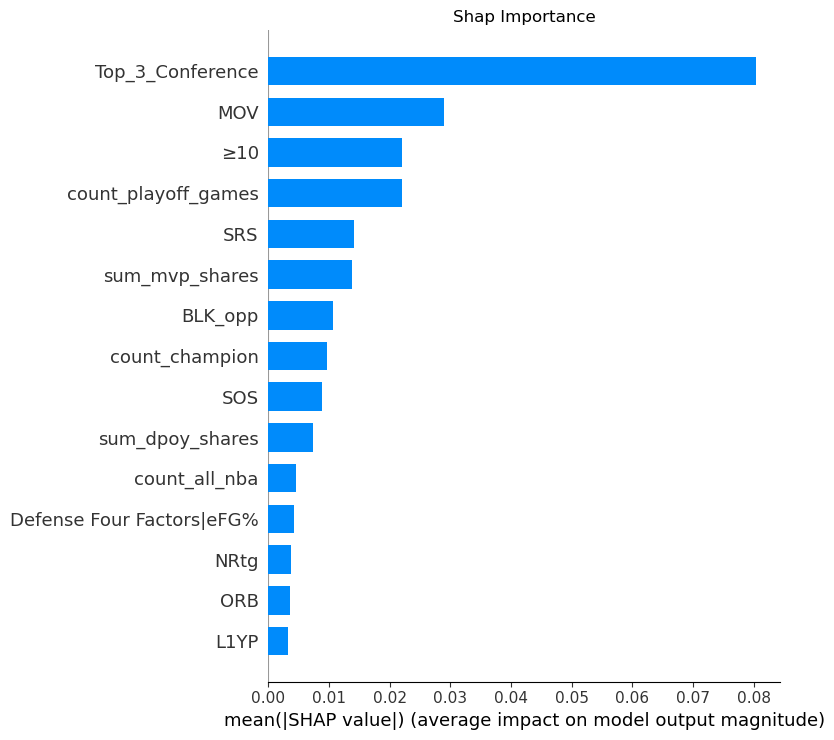

In [21]:
##Visualize the shap importance of the features that went into the model.
shap.summary_plot(shap_values, test_df, plot_type="bar", feature_names=col_names, 
                    show=False, max_display=15, class_inds="original")
fig = plt.gcf()
plt.title("Shap Importance")   
plt.tight_layout()
plt.show() 

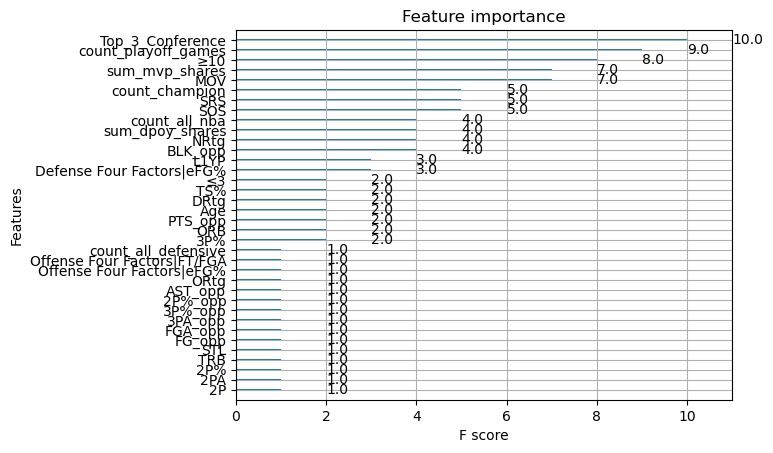

In [19]:
##Visualize the feature importance based on the F-score of the features that went into the model.
plot_importance(xgb)
plt.show()

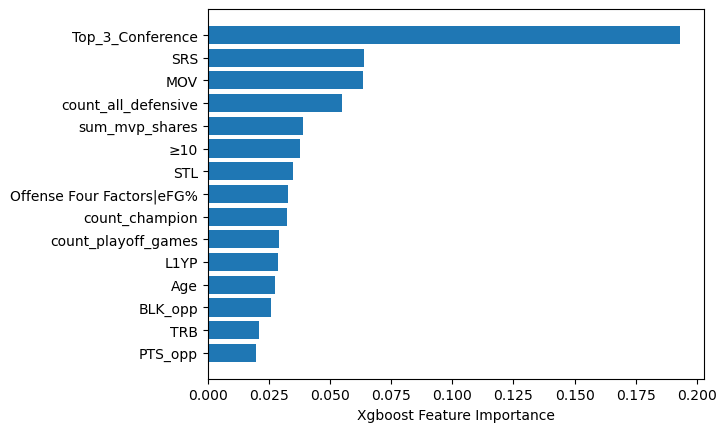

In [20]:
##Visualize the feature importance of the features that went into the model.
col_names = np.array(train_df.columns)
sorted_idx = xgb.feature_importances_.argsort()
last_15 = sorted_idx[-15:]
plt.barh(col_names[last_15], xgb.feature_importances_[last_15])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [35]:
np.flip(xgb.feature_importances_[last_15])

array([0.19305372, 0.0637413 , 0.06366115, 0.05511286, 0.03891366,
       0.03764632, 0.03497668, 0.03284992, 0.0325796 , 0.0290717 ,
       0.02891842, 0.02736364, 0.02597931, 0.02114295, 0.01975803],
      dtype=float32)

In [34]:
aaa

In [168]:
df_3_seasons

,season,name,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,L3YP,L6YP,L10YP,count_playoff_games,count_champion,sum_mvp_shares,sum_dpoy_shares,count_all_nba,count_all_defensive,Top_3_Conference
0,2022,Minnesota Timberwolves,41.6,91.0,0.457,14.8,41.3,0.358,26.8,49.7,...,0.000,0.0625,0.0625,119.0,0.0,0.000,0.025,1.0,3.0,False
16,2022,Sacramento Kings,40.5,88.1,0.460,11.4,33.2,0.344,29.1,54.9,...,0.000,0.0000,0.0000,0.0,0.0,0.000,0.000,0.0,0.0,False
1,2022,Miami Heat,39.6,84.8,0.467,13.6,35.8,0.379,26.0,49.0,...,0.875,1.3750,4.1875,415.0,3.0,0.021,0.141,6.0,8.0,True
29,2022,Indiana Pacers,41.4,89.5,0.463,12.2,35.4,0.344,29.3,54.1,...,0.000,0.3750,2.0625,0.0,0.0,0.000,0.000,0.0,0.0,False
28,2022,Chicago Bulls,41.7,86.9,0.480,10.6,28.8,0.369,31.1,58.1,...,0.000,0.1250,1.0000,204.0,2.0,0.033,0.000,2.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2020,Detroit Pistons,39.3,85.7,0.459,12.0,32.7,0.367,27.3,53.0,...,0.000,0.0000,0.0000,0.0,0.0,0.000,0.000,0.0,0.0,False
69,2020,Chicago Bulls,39.6,88.6,0.447,12.2,35.1,0.348,27.4,53.5,...,0.125,0.5625,1.6250,0.0,0.0,0.000,0.000,0.0,0.0,False
70,2020,Golden State Warriors,38.6,88.2,0.438,10.4,31.3,0.334,28.2,56.9,...,2.875,5.0000,5.3750,0.0,0.0,0.000,0.000,0.0,0.0,False
71,2020,New York Knicks,40.0,89.3,0.447,9.6,28.4,0.337,30.4,61.0,...,0.000,0.0000,0.4375,0.0,0.0,0.000,0.000,0.0,0.0,False


In [22]:
##Encode the only categorical variable in the dataset using the same encoder as before.
df_3_seasons['Top_3_Conference'] = labelencoder.transform(df_3_seasons['Top_3_Conference'])

In [23]:
df_3_seasons

,season,name,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,L3YP,L6YP,L10YP,count_playoff_games,count_champion,sum_mvp_shares,sum_dpoy_shares,count_all_nba,count_all_defensive,Top_3_Conference
0,2022,Minnesota Timberwolves,41.6,91.0,0.457,14.8,41.3,0.358,26.8,49.7,...,0.000,0.0625,0.0625,119.0,0.0,0.000,0.025,1.0,3.0,0
16,2022,Sacramento Kings,40.5,88.1,0.460,11.4,33.2,0.344,29.1,54.9,...,0.000,0.0000,0.0000,0.0,0.0,0.000,0.000,0.0,0.0,0
1,2022,Miami Heat,39.6,84.8,0.467,13.6,35.8,0.379,26.0,49.0,...,0.875,1.3750,4.1875,415.0,3.0,0.021,0.141,6.0,8.0,1
29,2022,Indiana Pacers,41.4,89.5,0.463,12.2,35.4,0.344,29.3,54.1,...,0.000,0.3750,2.0625,0.0,0.0,0.000,0.000,0.0,0.0,0
28,2022,Chicago Bulls,41.7,86.9,0.480,10.6,28.8,0.369,31.1,58.1,...,0.000,0.1250,1.0000,204.0,2.0,0.033,0.000,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2020,Detroit Pistons,39.3,85.7,0.459,12.0,32.7,0.367,27.3,53.0,...,0.000,0.0000,0.0000,0.0,0.0,0.000,0.000,0.0,0.0,0
69,2020,Chicago Bulls,39.6,88.6,0.447,12.2,35.1,0.348,27.4,53.5,...,0.125,0.5625,1.6250,0.0,0.0,0.000,0.000,0.0,0.0,0
70,2020,Golden State Warriors,38.6,88.2,0.438,10.4,31.3,0.334,28.2,56.9,...,2.875,5.0000,5.3750,0.0,0.0,0.000,0.000,0.0,0.0,0
71,2020,New York Knicks,40.0,89.3,0.447,9.6,28.4,0.337,30.4,61.0,...,0.000,0.0000,0.4375,0.0,0.0,0.000,0.000,0.0,0.0,0


### XGBoost Model Prediction and Result Visualization

2022
                    Team  Predicted Championship Score  \
0  Golden State Warriors                     74.001526   
1           Phoenix Suns                     66.224220   
2        Milwaukee Bucks                     64.308701   
3         Boston Celtics                     51.195763   
4             Miami Heat                     50.060673   

   Real Championship Score  
0                   100.00  
1                    43.75  
2                    43.75  
3                    87.50  
4                    68.75  


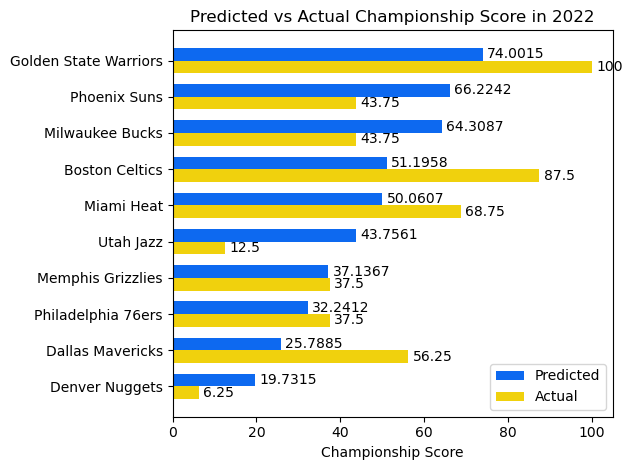

------------------------------------------------------------------------------
2021
                   Team  Predicted Championship Score  Real Championship Score
0             Utah Jazz                     64.209518                    37.50
1       Milwaukee Bucks                     57.551540                   100.00
2    Philadelphia 76ers                     56.943756                    43.75
3         Brooklyn Nets                     55.605835                    43.75
4  Los Angeles Clippers                     53.114540                    62.50


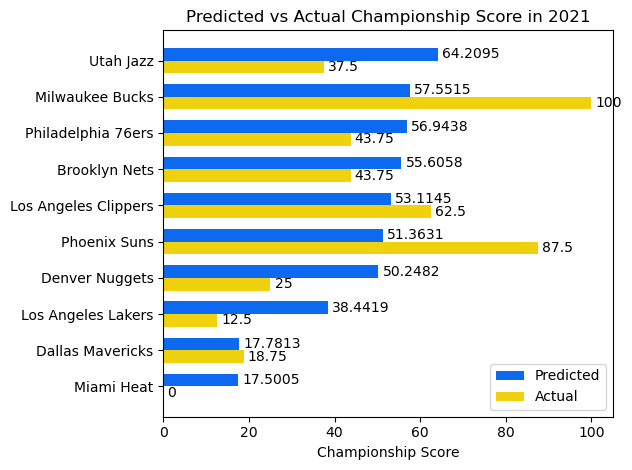

------------------------------------------------------------------------------
2020
                   Team  Predicted Championship Score  Real Championship Score
0    Los Angeles Lakers                     83.378387                   100.00
1       Milwaukee Bucks                     67.806778                    31.25
2  Los Angeles Clippers                     58.057995                    43.75
3       Toronto Raptors                     54.114937                    43.75
4        Boston Celtics                     50.765133                    62.50


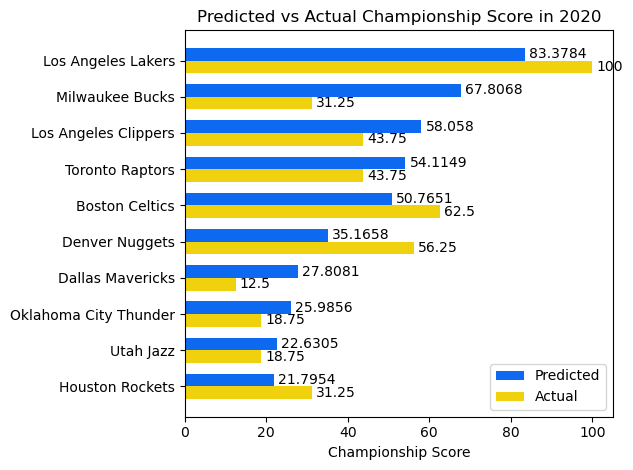

------------------------------------------------------------------------------


In [24]:
##Predict the championship score for each of the last 3 seasons using the model trained above.
##Then visualize the result, comparing between predicted and actual championship scores.
for season in df_3_seasons['season'].unique():
    pred_df = copy.deepcopy(df_3_seasons[df_3_seasons['season'] == season])
    team_name = pred_df['name'].values
    pred_y = pred_df['Champion_Win_Share'].values
    pred_df_y = pred_df[['name', 'season', 'Champion_Win_Share']]
    pred_df = pred_df.drop(['name', 'season', 'Champion_Win_Share'], axis=1)
    
    preds = xgb.predict(pred_df) * 100
    pred_df['season'] = season
    pred_df['Team'] = team_name
    pred_df['Predicted Championship Score'] = preds
    pred_df['Real Championship Score'] = pred_y * 100
    pred_df.sort_values(by=['Predicted Championship Score'], ascending=False, ignore_index=True, inplace=True)
    
    print(season)
    print(pred_df[['Team', 'Predicted Championship Score', 'Real Championship Score']].head(5))
    labels = list(pred_df['Team'])[:10]
    preds_means = list(pred_df['Predicted Championship Score'])[:10]
    real_means = list(pred_df['Real Championship Score'])[:10]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.barh(x - width/2, preds_means, width, label='Predicted', color='#0D69F0')
    rects2 = ax.barh(x + width/2, real_means, width, label='Actual', color='#F0D10D')

    ax.set_xlabel('Championship Score')
    ax.set_title('Predicted vs Actual Championship Score in ' + str(season))
    ax.set_yticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.invert_yaxis()
    ax.legend(loc='lower right')

    fig.tight_layout()

    plt.show()
    print('------------------------------------------------------------------------------')

## Random Forest Regressor

In [54]:
##Experiment with another model in Random Forest Regressor, perform the same GridSearchCV process to find the best parameters.
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 5, 7, 9],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [10, 20, 30, 40, 50]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, scoring="neg_root_mean_squared_error", verbose = 0)

grid_search.fit(train_df, train_y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [3, 5, 7, 9],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='neg_root_mean_squared_error')

In [55]:
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 10}


In [56]:
print(grid_search.best_score_)

-0.17156506204741107


In [25]:
##Build a Random Forest Regressor model using the best parameters determined above.
real_rf = RandomForestRegressor(max_depth=9, max_features=3, min_samples_leaf=4, min_samples_split=6, n_estimators=10, bootstrap=True, random_state=69, n_jobs=-1)

In [26]:
real_rf.fit(train_df, train_y)

RandomForestRegressor(max_depth=9, max_features=3, min_samples_leaf=4,
                      min_samples_split=6, n_estimators=10, n_jobs=-1,
                      random_state=69)

### Random Forest Regressor Feature Importances

In [27]:
real_rf.feature_importances_

array([0.00622774, 0.00285601, 0.00722569, 0.00591378, 0.0064961 ,
       0.02174168, 0.00036956, 0.00299764, 0.01160936, 0.00721767,
       0.0014786 , 0.00323097, 0.00568199, 0.01525926, 0.00798921,
       0.00642398, 0.00390886, 0.00130553, 0.00768154, 0.00214672,
       0.02069862, 0.00672338, 0.00682244, 0.0040722 , 0.00506923,
       0.00520512, 0.00549355, 0.00291161, 0.01334624, 0.01657404,
       0.0040882 , 0.00205514, 0.00688957, 0.0020484 , 0.01080921,
       0.00446848, 0.01384628, 0.0015247 , 0.04687106, 0.00180004,
       0.00336092, 0.00711102, 0.00615867, 0.05048371, 0.00999697,
       0.00888803, 0.03378375, 0.0192447 , 0.07761642, 0.00393464,
       0.00290243, 0.00441581, 0.02221722, 0.00256058, 0.00658619,
       0.00724803, 0.00064418, 0.02347257, 0.0020279 , 0.00382929,
       0.00705468, 0.01644949, 0.0433841 , 0.02343738, 0.01322205,
       0.01203247, 0.0032025 , 0.09012032, 0.0079754 , 0.01093705,
       0.03273514, 0.0714832 , 0.0290953 , 0.03330852])

Text(0.5, 0, 'Random Forest Feature Importance')

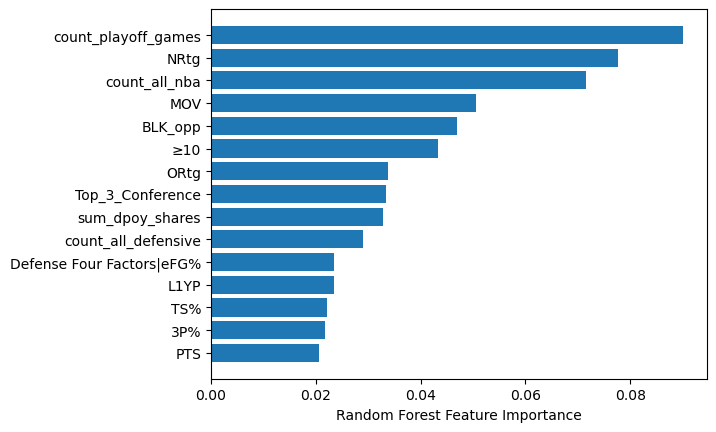

In [28]:
##Visualize the feature importance of the features that went into the model.
sorted_idx_rf = real_rf.feature_importances_.argsort()
last_15_rf = sorted_idx_rf[-15:]
plt.barh(col_names[last_15_rf], real_rf.feature_importances_[last_15_rf])
plt.xlabel("Random Forest Feature Importance")

### Random Forest Regressor Model Prediction and Result Visualization

2022
                    Team  Predicted Championship Score  \
0        Milwaukee Bucks                     69.059474   
1           Phoenix Suns                     63.492740   
2  Golden State Warriors                     53.004715   
3             Miami Heat                     46.085949   
4              Utah Jazz                     43.059253   

   Real Championship Score  
0                    43.75  
1                    43.75  
2                   100.00  
3                    68.75  
4                    12.50  


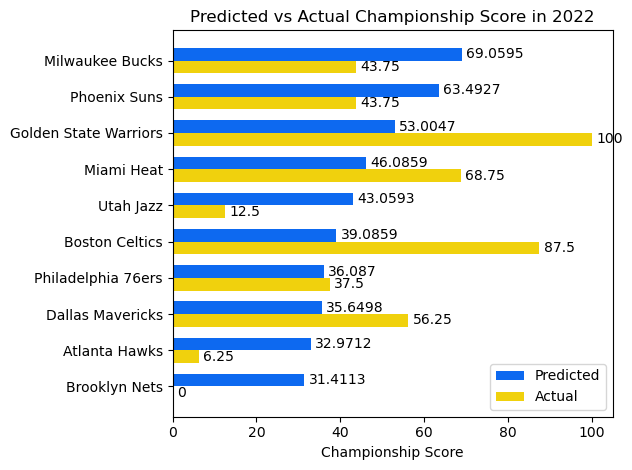

------------------------------------------------------------------------------
2021
                   Team  Predicted Championship Score  Real Championship Score
0    Los Angeles Lakers                     55.297033                    12.50
1  Los Angeles Clippers                     53.323950                    62.50
2          Phoenix Suns                     52.227746                    87.50
3         Brooklyn Nets                     51.618509                    43.75
4             Utah Jazz                     47.943795                    37.50


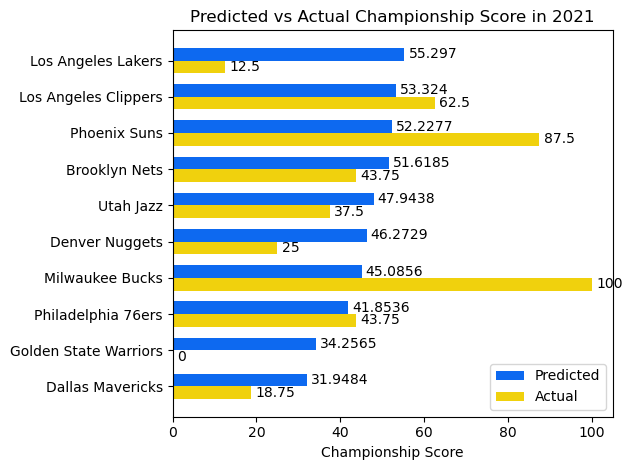

------------------------------------------------------------------------------
2020
                   Team  Predicted Championship Score  Real Championship Score
0       Milwaukee Bucks                     63.051140                    31.25
1    Los Angeles Lakers                     58.251716                   100.00
2  Los Angeles Clippers                     46.049080                    43.75
3        Boston Celtics                     43.351935                    62.50
4       Toronto Raptors                     36.416832                    43.75


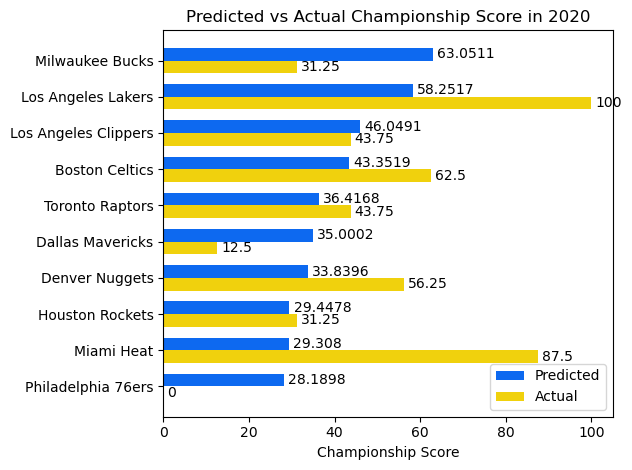

------------------------------------------------------------------------------


In [29]:
##Predict the championship score for each of the last 3 seasons using the model trained above.
##Then visualize the result, comparing between predicted and actual championship scores.
for season in df_3_seasons['season'].unique():
    pred_df = copy.deepcopy(df_3_seasons[df_3_seasons['season'] == season])
    team_name = pred_df['name'].values
    pred_y = pred_df['Champion_Win_Share'].values
    pred_df_y = pred_df[['name', 'season', 'Champion_Win_Share']]
    pred_df = pred_df.drop(['name', 'season', 'Champion_Win_Share'], axis=1)
    
    preds = real_rf.predict(pred_df) * 100
    pred_df['season'] = season
    pred_df['Team'] = team_name
    pred_df['Predicted Championship Score'] = preds
    pred_df['Real Championship Score'] = pred_y * 100
    pred_df.sort_values(by=['Predicted Championship Score'], ascending=False, ignore_index=True, inplace=True)
    
    print(season)
    print(pred_df[['Team', 'Predicted Championship Score', 'Real Championship Score']].head(5))
    labels = list(pred_df['Team'])[:10]
    preds_means = list(pred_df['Predicted Championship Score'])[:10]
    real_means = list(pred_df['Real Championship Score'])[:10]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.barh(x - width/2, preds_means, width, label='Predicted', color='#0D69F0')
    rects2 = ax.barh(x + width/2, real_means, width, label='Actual', color='#F0D10D')

    ax.set_xlabel('Championship Score')
    ax.set_title('Predicted vs Actual Championship Score in ' + str(season))
    ax.set_yticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.invert_yaxis()
    ax.legend(loc='lower right')

    fig.tight_layout()

    plt.show()
    print('------------------------------------------------------------------------------')

## Conclusion

### The analysis performed above, through multiple repeats, appears to be somewhat sensitive to the split between training and test data as well as the random state of the models. The results would vary to a certain degree, from predicting all past 3 NBA Champions correctly to predicting none correctly. Nonetheless, regardless of the model choice and data splits, the most critical factor remained consistent: whether or not a team finishes in the Top 3 of its respective conference during the regular season. This is an interesting observation since the teams performing well throughout 82 games can prove themselves to be strong contenders to make a deep run in the postseason. It also brings home-court advantage into play as higher seeds will enjoy one more game at home in a best-of-seven series. Moreover, the other factor that makes a team successful in the playoffs is the player's experience in those situations and his individual abilities. The more high-stake playoff games players on a team's roster have under their belts, the more a team is likely to benefit from it to perform well in clutch situations. Similarly, if a player has previous accolades in awards such as MVP or All-NBA-Team selections, he has shown incredible quality as a player that can potentially sway a game's result in his favor. From a logical standpoint, these factors make sense as to why they could have the most influence on a team's performance in the postseason. Even though the end predictions may not necessarily be correct 100% of the time, we can obtain a good sense of which teams will be competing in late May and early June for a piece of the Larry O'Brien NBA Championship Trophy.